<a href="https://colab.research.google.com/github/TimeIsTheChoice/ColabCaffe/blob/master/pascal_multilabel_with_datalayer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Caffe Prerpare

In [0]:
#@title Check Cuda_Tools_Version {display-mode: "form"}
!nvidia-smi
!nvcc -V
# This code will be hidden when the notebook is loaded.


In [0]:
#@title Install V10.0.130 {display-mode: "form"}
If_not_10_0_130_click_box = False #@param {type:"boolean"}
if If_not_10_0_130_click_box:
  !apt  --purge remove "cublas*" "cuda*"
  !apt  --purge remove "nvidia*" 
  !wget https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64/cuda-repo-ubuntu1804_10.0.130-1_amd64.deb
  !apt-key adv --fetch-keys https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64/7fa2af80.pub && sudo apt update
  !dpkg -i cuda-repo-ubuntu1804_10.0.130-1_amd64.deb
  #!apt update
  !apt install -y cuda=10.0.130-1

  # Install CuDNN 7 and NCCL 2
  !wget https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64/nvidia-machine-learning-repo-ubuntu1804_1.0.0-1_amd64.deb
  !dpkg -i nvidia-machine-learning-repo-ubuntu1804_1.0.0-1_amd64.deb

  #!apt update
  !apt install -y libcudnn7 libcudnn7-dev libnccl2 libc-ares-dev

  !apt autoremove
  #!apt upgrade

  # Link libraries to standard locations
  !mkdir -p /usr/local/cuda-10.0/nccl/lib
  !ln -s /usr/lib/x86_64-linux-gnu/libnccl.so.2 /usr/local/cuda/nccl/lib/
  !ln -s /usr/lib/x86_64-linux-gnu/libcudnn.so.7 /usr/local/cuda-10.0/lib64/  
else:
  print("version correct,goning on!")
# This code will be hidden when the notebook is loaded.


version correct,goning on!


In [0]:
#@title clone caffe and install dependence {display-mode: "form"}
import os
dirname = os.path.abspath('/content/caffe')
if not os.path.exists(dirname):
  !apt install python3-opencv
  !apt-get install libopenblas-dev # OpenBLAS
  # Other dependencies
  !apt-get install libprotobuf-dev libleveldb-dev libsnappy-dev libopencv-dev libhdf5-serial-dev protobuf-compiler
  !apt-get install — no-install-recommends libboost-all-dev
  !apt-get install libgflags-dev libgoogle-glog-dev liblmdb-dev
  !pip3 install protobuf
  !apt-get install the python3-dev


  os.chdir('/content')
  !rm -rf caffe
  !git clone https://github.com/TimeIsTheChoice/caffe.git
  !cd caffe
else:
  print("Caffe exist!")

# This code will be hidden when the notebook is loaded.


In [0]:
#@title Delete & RePull Caffe {display-mode: "form"}
delete_caffe = False #@param {type:"boolean"}
if delete_caffe:
  os.chdir('/content')
  !rm -rf caffe*
  !git clone https://github.com/TimeIsTheChoice/caffe.git
  !cd caffe
# This code will be hidden when the notebook is loaded.


In [0]:
#@title Get cpu cores number {display-mode: "form"}
!nproc --all
!echo "Threads/core: $(nproc --all)"
# This code will be hidden when the notebook is loaded.


In [0]:
#@title If build faild,click me! {display-mode: "form"}
Build_Failed = False #@param {type:"boolean"}
import os
if Build_Failed:
  os.chdir("/content/caffe")
  !make clean
else:
  print("nothing happen!")
# This code will be hidden when the notebook is loaded.


In [0]:
#@title Build Caffe {display-mode: "form"}
Build_Caffe = True #@param {type:"boolean"}
if Build_Caffe:
  import os
  os.chdir('/content/caffe')
  !make all -j$(nproc --all) # 4 represents number of CPU Cores
  !make pycaffe -j$(nproc --all) # 4 represents number of CPU Cores
  !export PYTHONPATH=~/caffe/python:$PYTHONPATH
else:
  print("Make sure you want build it,please!")
# This code will be hidden when the notebook is loaded.


In [0]:
  !export PYTHONPATH=~/caffe/python:$PYTHONPATH

In [4]:
#@title check Caffe  {display-mode: "form"}
caffe_root = '/content/caffe/'  # this file should be run from {caffe_root}/examples (otherwise change this line)

import sys
sys.path.insert(0, caffe_root + 'python')
import caffe
print("import successful!")
# This code will be hidden when the notebook is loaded.


import successful!


In [0]:
#@title Check runtime whetehr gpu or not {display-mode: "form"}
#' ' means CPU whereas '/device:G:0' means GPU
import tensorflow as tf
tf.test.gpu_device_name()
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())
# This code will be hidden when the notebook is loaded.


In [0]:
#@title check GPU memory utilization {display-mode: "form"}
# memory footprint support libraries/code
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize
import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
 process = psutil.Process(os.getpid())
 print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
 print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm() 
# This code will be hidden when the notebook is loaded.


# Multilabel classification on PASCAL using python data-layers

In this tutorial we will do multilabel classification on **PASCAL VOC 2012**.

**Multilabel classification** is a generalization of **multiclass classification**, where each instance (image) can belong to many classes. 

For example, 
>an image may both belong to a `"beach"` category and a `"vacation pictures"` category. In multiclass classification, on the other hand, each image belongs to a single class.

Caffe supports multilabel classification through the `SigmoidCrossEntropyLoss` layer, and we will load data using a `Python data layer`. 

>pascal_multilabel_datalayers.py

Data could also be provided through HDF5 or LMDB data layers, but the python data layer provides endless flexibility, so that's what we will use.

### 1. Preliminaries

* First, make sure you compile caffe using
WITH_PYTHON_LAYER := 1

* Second, download PASCAL VOC 2012. It's available here: http://host.robots.ox.ac.uk/pascal/VOC/voc2012/index.html

* Third, import modules:

In [0]:
dir_name='/content/caffe/examples'
os.chdir(dir_name)

In [0]:
#@title download pascal dataset {display-mode: "form"}
!wget -O /content/caffe/data/VOCtrainval_11-May-2012.tar  --no-check-certificate http://host.robots.ox.ac.uk/pascal/VOC/voc2012/VOCtrainval_11-May-2012.tar 
import tarfile
my_tar = tarfile.open('/content/caffe/data/VOCtrainval_11-May-2012.tar')
my_tar.extractall('/content/caffe/data/') # specify which folder to extract to
my_tar.close()
!mv /content/caffe/data/VOCdevkit /content/caffe/data/pascal
# This code will be hidden when the notebook is loaded.


In [0]:
import sys 
import os

import numpy as np
import os.path as osp
import matplotlib.pyplot as plt

from copy import copy

% matplotlib inline
plt.rcParams['figure.figsize'] = (6, 6)

caffe_root = '../'  # this file is expected to be in {caffe_root}/examples
sys.path.append(caffe_root + 'python')
import caffe # If you get "No module named _caffe", either you have not built pycaffe or you have the wrong path.

from caffe import layers as L, params as P # Shortcuts to define the net prototxt.

sys.path.append("pycaffe/layers") # the datalayers we will use are in this directory.
sys.path.append("pycaffe") # the tools file is in this folder

import pycaffe.tools #this contains some tools that we need
from pycaffe.tools import CaffeSolver
from caffe import SGDSolver
import pycaffe.layers.pascal_multilabel_datalayers

import tools #this contains some tools that we need

* Fourth, set data directories and initialize caffe

In [23]:
# set data root directory, e.g:
pascal_root = osp.join(caffe_root, 'data/pascal/VOC2012')

# these are the PASCAL classes, we'll need them later.
classes = np.asarray(['aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike', 'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor'])
print('Class size :{}'.format(len(classes)))
# make sure we have the caffenet weight downloaded.
if not os.path.isfile(caffe_root + 'models/bvlc_reference_caffenet/bvlc_reference_caffenet.caffemodel'):
    print("Downloading pre-trained CaffeNet model...")
    !../scripts/download_model_binary.py ../models/bvlc_reference_caffenet

# initialize caffe for gpu mode
caffe.set_device(0)
caffe.set_mode_gpu()

Class size :20


### 2. Define network prototxts

* Let's start by defining the nets using caffe.NetSpec. Note how we used the SigmoidCrossEntropyLoss layer. This is the right loss for multilabel classification. Also note how the data layer is defined.

In [0]:
# helper function for common structures
def conv_relu(bottom, ks, nout, stride=1, pad=0, group=1):
    conv = L.Convolution(bottom, kernel_size=ks, stride=stride,
                                num_output=nout, pad=pad, group=group)
    return conv, L.ReLU(conv, in_place=True)

# another helper function
def fc_relu(bottom, nout):
    fc = L.InnerProduct(bottom, num_output=nout)
    return fc, L.ReLU(fc, in_place=True)

# yet another helper function
def max_pool(bottom, ks, stride=1):
    return L.Pooling(bottom, pool=P.Pooling.MAX, kernel_size=ks, stride=stride)

# main netspec wrapper
def caffenet_multilabel(data_layer_params, datalayer):
    # setup the python data layer 
    n = caffe.NetSpec()
    n.data, n.label = L.Python(module = 'pascal_multilabel_datalayers', layer = datalayer, 
                               ntop = 2, param_str=str(data_layer_params))

    # the net itself
    n.conv1, n.relu1 = conv_relu(n.data, 11, 96, stride=4)
    n.pool1 = max_pool(n.relu1, 3, stride=2)
    n.norm1 = L.LRN(n.pool1, local_size=5, alpha=1e-4, beta=0.75)
    n.conv2, n.relu2 = conv_relu(n.norm1, 5, 256, pad=2, group=2)
    n.pool2 = max_pool(n.relu2, 3, stride=2)
    n.norm2 = L.LRN(n.pool2, local_size=5, alpha=1e-4, beta=0.75)
    n.conv3, n.relu3 = conv_relu(n.norm2, 3, 384, pad=1)
    n.conv4, n.relu4 = conv_relu(n.relu3, 3, 384, pad=1, group=2)
    n.conv5, n.relu5 = conv_relu(n.relu4, 3, 256, pad=1, group=2)
    n.pool5 = max_pool(n.relu5, 3, stride=2)
    n.fc6, n.relu6 = fc_relu(n.pool5, 4096)
    n.drop6 = L.Dropout(n.relu6, in_place=True)
    n.fc7, n.relu7 = fc_relu(n.drop6, 4096)
    n.drop7 = L.Dropout(n.relu7, in_place=True)
    n.score = L.InnerProduct(n.drop7, num_output=20)
    n.loss = L.SigmoidCrossEntropyLoss(n.score, n.label)
    
    return str(n.to_proto())

### 3. Write nets and solver files

* Now we can crete net and solver prototxts. For the solver, we use the CaffeSolver class from the "tools" module

In [0]:
workdir = './pascal_multilabel_with_datalayer'
if not os.path.isdir(workdir):
    os.makedirs(workdir)

solverprototxt = CaffeSolver(trainnet_prototxt_path = osp.join(workdir, "trainnet.prototxt"), testnet_prototxt_path = osp.join(workdir, "valnet.prototxt"))
solverprototxt.sp['display'] = "1"
solverprototxt.sp['base_lr'] = "0.0001"
solverprototxt.sp['max_iter'] = "50"# it's no use to pycaffe
solverprototxt.sp['snapshot'] = "100"
#https://github.com/BVLC/caffe/wiki/Solver-Prototxt
#solverprototxt.sp['type'] = "Nesterov"
solverprototxt.write(osp.join(workdir, 'solver.prototxt'))

# write train net.
with open(osp.join(workdir, 'trainnet.prototxt'), 'w') as f:
    # provide parameters to the data layer as a python dictionary. Easy as pie!
    data_layer_params = dict(batch_size = 128, im_shape = [227, 227], split = 'train', pascal_root = pascal_root)
    f.write(caffenet_multilabel(data_layer_params, 'PascalMultilabelDataLayerSync'))

# write validation net.
with open(osp.join(workdir, 'valnet.prototxt'), 'w') as f:
    data_layer_params = dict(batch_size = 128, im_shape = [227, 227], split = 'val', pascal_root = pascal_root)
    f.write(caffenet_multilabel(data_layer_params, 'PascalMultilabelDataLayerSync'))

* This net uses a python datalayer: 'PascalMultilabelDataLayerSync', which is defined in './pycaffe/layers/pascal_multilabel_datalayers.py'. 

* Take a look at the code. It's quite straight-forward, and gives you full control over data and labels.

* Now we can load the caffe solver as usual.

In [80]:
solver = caffe.AdamSolver(osp.join(workdir, 'solver.prototxt'))
#solver.net.copy_from(caffe_root + 'models/bvlc_reference_caffenet/bvlc_reference_caffenet.caffemodel')
solver.test_nets[0].share_with(solver.net)
solver.step(1)

BatchLoader initialized with 5717 images
PascalMultilabelDataLayerSync initialized for split: train, with bs: 128, im_shape: [227, 227].
BatchLoader initialized with 5823 images
PascalMultilabelDataLayerSync initialized for split: val, with bs: 128, im_shape: [227, 227].


* Let's check the data we have loaded.

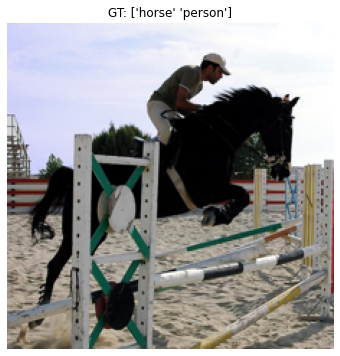

In [60]:
transformer = tools.SimpleTransformer() # This is simply to add back the bias, re-shuffle the color channels to RGB, and so on...
image_index = 0 # First image in the batch.
plt.figure()
plt.imshow(transformer.deprocess(copy(solver.net.blobs['data'].data[image_index, ...])))
gtlist = solver.net.blobs['label'].data[image_index, ...].astype(np.int)
plt.title('GT: {}'.format(classes[np.where(gtlist)]))
plt.axis('off');

* NOTE: we are readin the image from the data layer, so the resolution is lower than the original PASCAL image.

### 4. Train a net.

* Let's train the net. First, though, we need some way to measure the accuracy. Hamming distance is commonly used in multilabel problems. We also need a simple test loop. Let's write that down. 

In [86]:
%%timeit
caffe.set_device(0)
caffe.set_mode_gpu()
solver.step(1)
!rm -rf  /content/caffe/examples/snapshot_iter_*

1 loop, best of 3: 2.87 s per loop


In [0]:
def hamming_distance(gt, est):
    return sum([1 for (g, e) in zip(gt, est) if g == e]) / float(len(gt))

def check_accuracy(net, num_batches, batch_size = 128):
    acc = 0.0
    for t in range(num_batches):
        net.forward()
        gts = net.blobs['label'].data
        ests = net.blobs['score'].data > 0
        for gt, est in zip(gts, ests): #for each ground truth and estimated label vector
            acc += hamming_distance(gt, est)
    return acc / (num_batches * batch_size)

* Alright, now let's train for a while

In [99]:
max_iter = 1000
test_iter=100
for itt in range(max_iter):
    solver.step(1)#https://stackoverflow.com/questions/38025639/caffe-lenet-difference-between-solver-step1-and-solver-net-forward
    if not itt%test_iter:
      print( 'itt:{:3d}'.format(itt), 'accuracy:{0:.4f}'.format(check_accuracy(solver.test_nets[0], 50)))

itt:  0 accuracy:0.9301
itt:100 accuracy:0.9549
itt:200 accuracy:0.9574
itt:300 accuracy:0.9558
itt:400 accuracy:0.9534
itt:500 accuracy:0.9550
itt:600 accuracy:0.9533
itt:700 accuracy:0.9549
itt:800 accuracy:0.9541
itt:900 accuracy:0.9546


* Great, the accuracy is increasing, and it seems to converge rather quickly. It may seem strange that it starts off so high but it is because the ground truth is sparse. There are 20 classes in PASCAL, and usually only one or two is present. So predicting all zeros yields rather high accuracy. Let's check to make sure.

In [0]:
def check_baseline_accuracy(net, num_batches, batch_size = 128):
    acc = 0.0
    for t in range(int(num_batches)):
        net.forward()
        gts = net.blobs['label'].data
        ests = np.zeros((batch_size, len(gts)))
        #print(len(gts),ests.shape)#128 (128, 128)
        for gt, est in zip(gts, ests): #for each ground truth and estimated label vector
            #print(gt,est)#(20,) (128,)
            acc += hamming_distance(gt, est)
    return acc / (num_batches * batch_size)

print('Baseline accuracy:{0:.4f}'.format(check_baseline_accuracy(solver.test_nets[0], 5823/128)))

### 6. Look at some prediction results

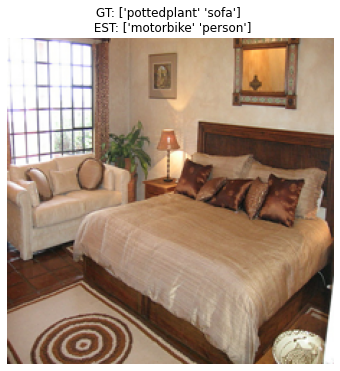

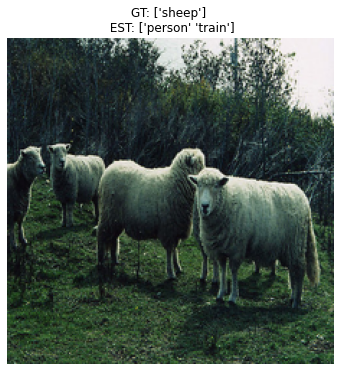

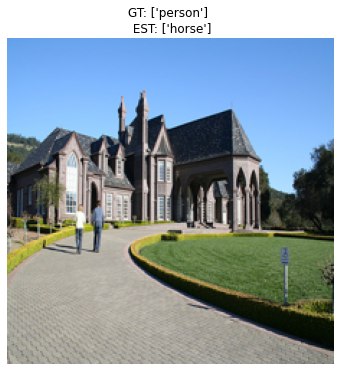

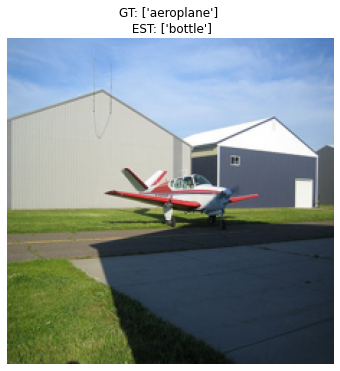

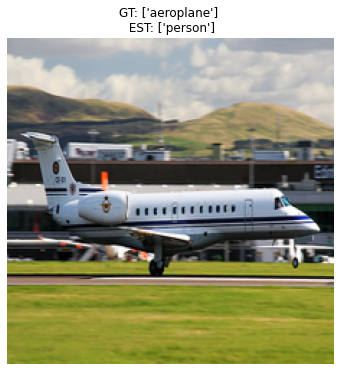

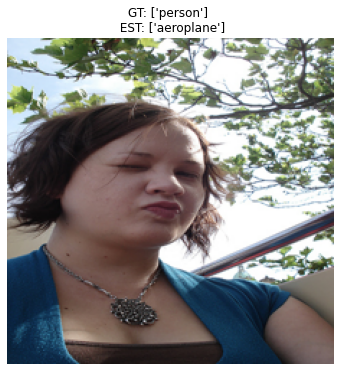

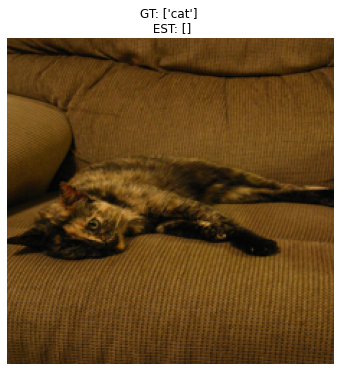

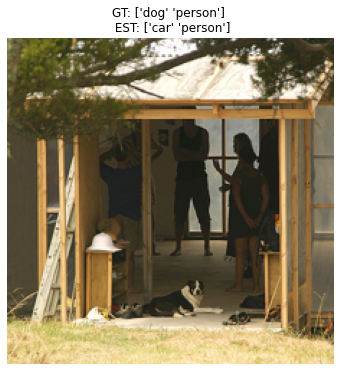

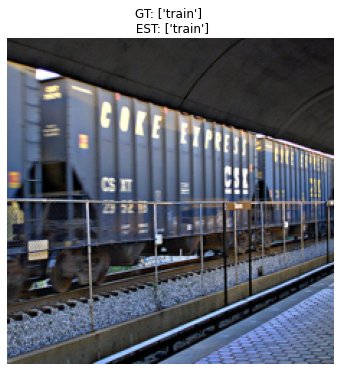

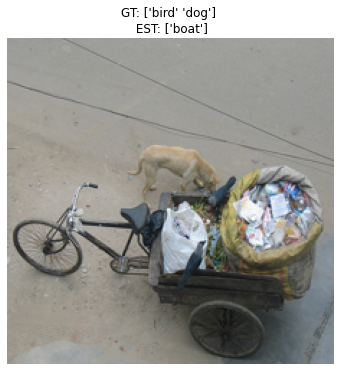

In [106]:
test_net = solver.test_nets[0]
for image_index in range(10):
    plt.figure()
    plt.imshow(transformer.deprocess(copy(test_net.blobs['data'].data[image_index, ...])))
    gtlist = test_net.blobs['label'].data[image_index, ...].astype(np.int)
    estlist = test_net.blobs['score'].data[image_index, ...] > 0
    plt.title('GT: {} \n EST: {}'.format(classes[np.where(gtlist)], classes[np.where(estlist)]))
    plt.axis('off')